In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, mean_absolute_error

In [2]:
df = pd.read_csv("train.csv")

```
client_id                идентификатор клиента
education                уровень образования
sex                      пол заёмщика
age                      возраст заёмщика
car                      флаг наличия автомобиля
car_type                 флаг автомобиля-иномарки
decline_app_cnt          количество отказанных прошлых заявок
good_work                флаг наличия «хорошей» работы
bki_request_cnt          количество запросов в БКИ
home_address             категоризатор домашнего адреса
work_address             категоризатор рабочего адреса
income                   доход заёмщика
foreign_passport         наличие загранпаспорта
default                  наличие дефолта
```

In [3]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0
3,16222,SCH,F,53,N,N,0,0,2,2,3,10000,N,0
4,101655,GRD,M,48,N,N,0,1,1,2,3,30000,Y,0


Построим диаграмму для переменной default. Клиентов без дефолта у банка больше?

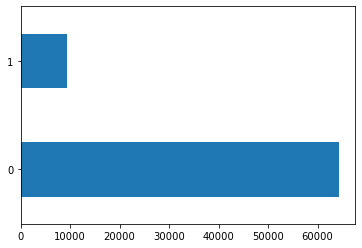

In [4]:
df.default.value_counts().plot.barh();

Посмотрим на тип данных и наличие пропусков:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения. Значит, нам необходима предварительная очистка данных.
Как мы видим, пропуски встречаются только в информации об образовании клиентов. Посмотрим на признак ближе:

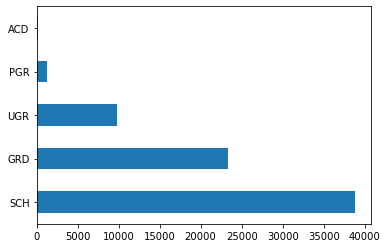

In [6]:
df.education.value_counts().plot.barh();

Заменим пропуски на NAN_EDU

In [7]:
df.education = df.education.fillna("NAN_EDU")

### Посмотрим на распределение числовых данных:

In [8]:
num_cols = ['age','decline_app_cnt','bki_request_cnt','income']

<Figure size 720x1080 with 0 Axes>

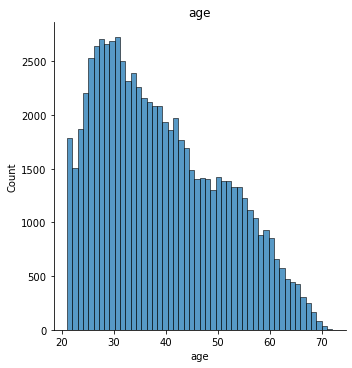

<Figure size 720x1080 with 0 Axes>

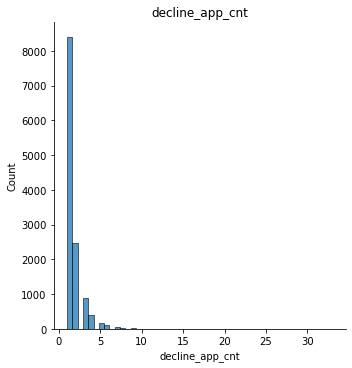

<Figure size 720x1080 with 0 Axes>

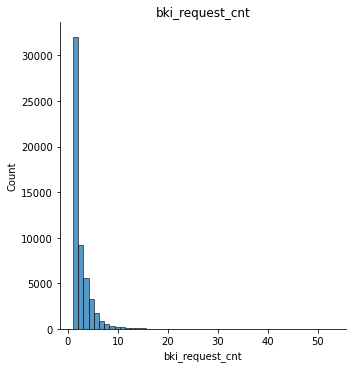

<Figure size 720x1080 with 0 Axes>

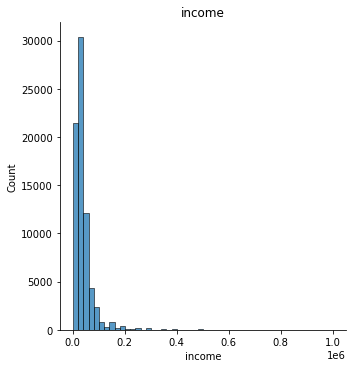

In [9]:
for i in num_cols:
    plt.figure(figsize=(10, 15))
    sns.displot(df[i][df[i] > 0].dropna(), kde = False, rug=False, bins = 50)
    plt.title(i)
    plt.show()

После построения гистограмм стало очевидно, что распределения всех числовых переменных имеют тяжёлый правый хвост. Чтобы сделаеть распределение более нормальным, можно работать с логарифмированными величинами этих переменных.


In [10]:
df.income = np.log(df.income)
df.age = np.log(df.age)
df.bki_request_cnt = np.log(df.bki_request_cnt + 1)
df.decline_app_cnt = np.log(df.decline_app_cnt + 1)

Оценим корреляцию Пирсона для непрерывных переменных по формуле:

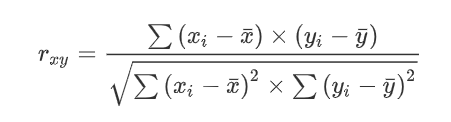

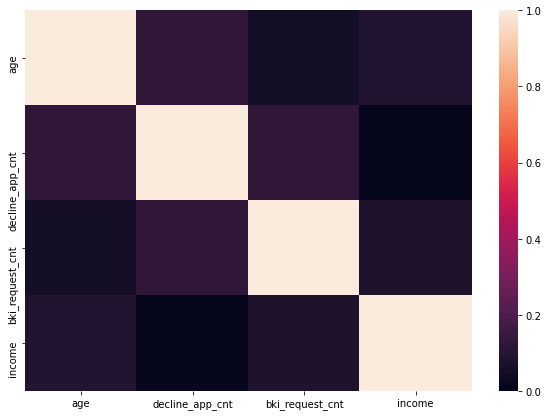

In [11]:
plt.subplots(figsize=(10, 7))
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1);

In [12]:
df[num_cols].corr()

,age,decline_app_cnt,bki_request_cnt,income
age,1.000000,-0.127905,0.049478,-0.091870
decline_app_cnt,-0.127905,1.000000,0.125163,-0.013868
bki_request_cnt,0.049478,0.125163,1.000000,0.081019
income,-0.091870,-0.013868,0.081019,1.000000


Для оценки значимости числовых переменных будем использовать функцию [f_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html) из библиотеки sklearn. 

Возможности модуля [sklearn.feature_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) могут быть использованы не только для выбора важных признаков, но и для уменьшения размерности, улучшения предсказательной силы моделей, либо для повышения их производительности на очень многомерных наборах данных.

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t). 

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

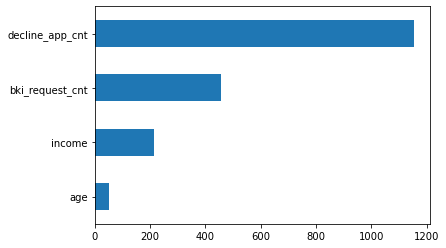

In [13]:
imp_num = Series(f_classif(df[num_cols], df.default)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

### Посмотрим на категориальные данные:

Чтобы алгоритмы машинного обучения могли работать с категориальными данными, их нужно преобразовать в числа

In [14]:
df.columns

Index(['client_id', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'bki_request_cnt', 'home_address',
       'work_address', 'income', 'foreign_passport', 'default'],
      dtype='object')

In [15]:
bin_cols = ['sex', 'car', 'good_work', 'foreign_passport', 'car_type']

In [16]:
# Преобразуем бинарные признаки с помощью LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [17]:
# Убедимся в преобразовании    
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,1,4.127134,1,1,0.000000,0,0.693147,1,2,9.798127,0,0
1,63161,SCH,0,4.077537,0,0,0.000000,0,1.386294,2,3,9.852194,0,0
2,25887,SCH,1,3.218876,1,0,1.098612,0,0.693147,1,2,10.308953,1,0
3,16222,SCH,0,3.970292,0,0,0.000000,0,1.098612,2,3,9.210340,0,0
4,101655,GRD,1,3.871201,0,0,0.000000,1,0.693147,2,3,10.308953,1,0


In [18]:
# Для проверки закодированных значений
print(dict(enumerate(label_encoder.classes_)))

{0: 'N', 1: 'Y'}


ЗНАЧИМОСТЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

Для оценки значимости категориальных и бинарных переменных будем использовать функцию [mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

In [19]:
cat_cols = ['home_address', 'work_address', 'education']

In [30]:
df.education.fillna('NAN_EDU',inplace=True)

df.education = label_encoder.fit_transform(df.education)

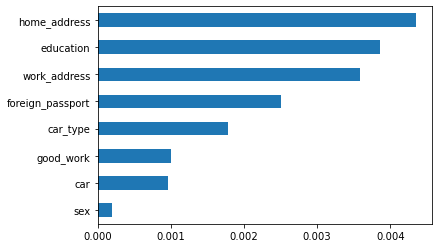

In [31]:
imp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Перед обучением регрессии нам следует стандартизировать числовые признаки, а также воспользоваться dummy-кодированием для категориальных переменных, то есть создать отдельную бинарную переменную для каждой категории.

In [33]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)
X_cat.shape

(73799, 11)

In [34]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(df[num_cols].values)

In [35]:
# Объединяем

X = np.hstack([X_num, df[bin_cols].values, X_cat])
Y = df['default'].values

In [36]:
# Разделим данные для обучения следующим образом:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [37]:
# Предподготавливаем данные

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [38]:
# Создаём модель
model = LogisticRegression()

# Обучаем модель на тестовом наборе данных
model.fit(X_train,y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
probs = model.predict_proba(X_test)
probs = probs[:,1]

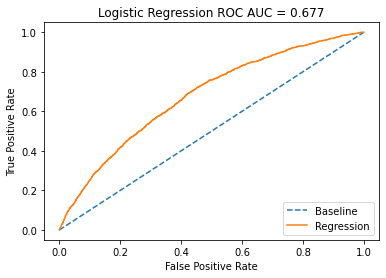

In [39]:
# Сравниваем предсказанные значения (probs) с реальными (y_test)
fpr, tpr, threshold = roc_curve(y_test, probs)

roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Найдем оптимальное значение параметра регуляризации для логистической регрессии. Рассмотрим поиск гиперпараметров GridSearchCV при помощи перебора параметров по сетке с последующей кросс-валидацией. 

In [40]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# Показать лучшие гиперпараметры
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0
